In [1]:
import numpy as np
import pandas as pd
import glob
import os
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from scipy import stats
from scipy.optimize import curve_fit

pd.options.mode.chained_assignment = None

## Analysis of COVID-19 Data

In this file some analysis of the timeseries data for the COVID-19 pandemic is performed. 
After gathering, and preparing the data, first we take a look at latest numbers.
Then we see if we can fit an exponential forecast model and make a projection into the future

### 1. Gather Data

data is published by Johns Hopkins University:
    - https://github.com/CSSEGISandData/COVID-19
    - https://systems.jhu.edu/research/public-health/ncov/s

In [2]:
pth_str = 'JohnsHopkins Data\csse_covid_19_time_series'

# load timeseries data for confirmed, recovered and deaths from published files and store in sepearte dataframes
df_c = pd.read_csv(pth_str + '\\time_series_19-covid-Confirmed.csv').groupby(['Country/Region']).sum()
df_r = pd.read_csv(pth_str + '\\time_series_19-covid-Recovered.csv').groupby(['Country/Region']).sum()
df_d = pd.read_csv(pth_str + '\\time_series_19-covid-Deaths.csv').groupby(['Country/Region']).sum()

# # check if index and columns are equal
# any(df_c.index != df_r.index)
# any(df_c.index != df_d.index)
# any(df_c.columns != df_r.columns)    
# any(df_c.columns != df_d.columns)

### 2. Prepare data

In [3]:
# what is the last available data?
date_latest = dt.datetime.strptime(df_c.columns[-1],'%m/%d/%y')
date_latest_str = date_latest.strftime('%x')
print('latest update: %s' % date_latest_str)

# get actual numbers
dfl = pd.DataFrame()
dfl.loc[:,'Confirmed'] = df_c.iloc[:,-1]
dfl.loc[:,'Recovered'] = df_r.iloc[:,-1]
dfl.loc[:,'Deaths'] = df_d.iloc[:,-1]

# calculate infections
dfl.loc[:,'Infections'] = dfl.loc[:,'Confirmed'] - dfl.loc[:,'Recovered'] - dfl.loc[:,'Deaths']
dfl = dfl.sort_values(by='Infections', ascending=False)

latest update: 03/16/20


### 3. Analyse Data

                  Confirmed Recovered Deaths Infections
China                 81033     67910   3217       9906
Rest of the world    100513     10178   3909      86426

 total reported numbers (03/16/20)

Shares based on total reported numbers:
                  Confirmed Recovered    Deaths Infections
China               0.44635   0.86966  0.451445   0.102832
Rest of the world   0.55365   0.13034  0.548555   0.897168


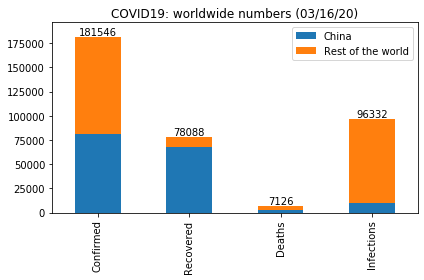

In [4]:
# --> How are latest Numbers in China vs Rest of the World?
dfl2 = pd.DataFrame(columns=['Confirmed','Recovered','Deaths','Infections'])
dfl2.loc['China'] = dfl.loc['China']
dfl2.loc['Rest of the world'] = dfl.loc[dfl.index != 'China'].sum()

print(dfl2)

# --> What are the shares 
print('\n total reported numbers (%s)' % date_latest_str)
dfl2_shares = dfl2/dfl.sum()

print('\nShares based on total reported numbers:')
print(dfl2_shares)

# plot
dfl2.T.plot(kind='bar',stacked=True)
plt.title('COVID19: worldwide numbers (%s)' % date_latest_str);

for i, v in enumerate(dfl2.sum()):
    plt.text(i, v + 2000, ('%4.0f' % v), color='k',horizontalalignment='center')

plt.ylim(top = dfl2['Confirmed'].sum() + 15e3);
plt.tight_layout()
plt.savefig('Bilder/Numbers.png', bbox_inches='tight')

top 10 countries: (Italy; China; Iran; Spain; Germany; Korea, South; France; US; Switzerland; United Kingdom)
                Confirmed  Recovered  Deaths  Infections  Deaths_ratio  \
Country/Region                                                           
Italy               27980       2749    2158       23073      0.077127   
China               81033      67910    3217        9906      0.039700   
Iran                14991       4590     853        9548      0.056901   
Spain                9942        530     342        9070      0.034400   
Germany              7272         67      17        7188      0.002338   
Korea, South         8236       1137      75        7024      0.009106   
France               6650         12     148        6490      0.022256   
US                   4632         17      85        4530      0.018351   
Switzerland          2200          4      14        2182      0.006364   
United Kingdom       1551         21      56        1474      0.036106   

 

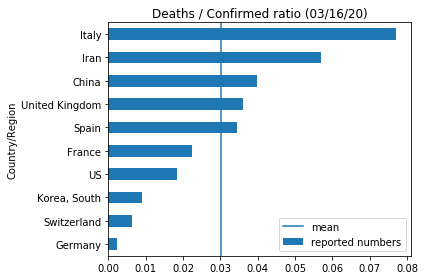

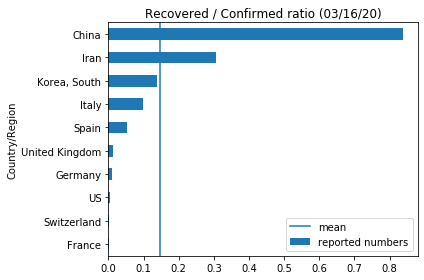

In [5]:
#--> What are currently the top 10 countries based on infection numbers??

topX = dfl[:10]
topX_str = ('; ').join(topX.index)
print('top 10 countries: (%s)' % topX_str)

# --> What are the recovering / death - rates?
topX.loc[:,'Deaths_ratio'] = topX.loc[:,'Deaths'] / topX.loc[:,'Confirmed']
topX.loc[:,'Recovered_ratio'] = topX.loc[:,'Recovered'] / topX.loc[:,'Confirmed']

#plot Death Ratio per country
fig = plt.figure()
topX.Deaths_ratio.sort_values(ascending=True).plot(kind='barh', label='reported numbers')
plt.axvline(topX.loc[:,'Deaths_ratio'].mean(), label='mean')
plt.title('Deaths / Confirmed ratio (%s)' % date_latest_str)
plt.legend()
plt.tight_layout()

#plot Recovered Ratio per country
fig = plt.figure()
topX.Recovered_ratio.sort_values(ascending=True).plot(kind='barh', label='reported numbers')
plt.axvline(topX.loc[:,'Recovered_ratio'].mean(), label='mean')
plt.title('Recovered / Confirmed ratio (%s)' % date_latest_str)
plt.legend()
plt.tight_layout()

print(topX)


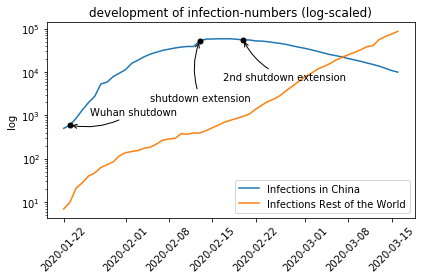

In [6]:
#--> How are infection numbers developing over time? 

# Calculate timeseries of infections
df_i = df_c - df_r -df_d;

# drop geographical information, since we dont need it
df_i = df_i.drop(['Lat','Long'], axis=1).T
df_i.index = pd.to_datetime(df_i.index)

# plot Infections in China vs. Rest of the world
df_i_rest = df_i.loc[:,df_i.columns != 'China'].sum(axis = 1)

# plot stats
fig, ax = plt.subplots()

ax.semilogy(df_i.loc[:,'China'], label='Infections in China');
ax.semilogy(df_i_rest, label='Infections Rest of the World');

# plot annotations
ld_dates =pd.to_datetime(('2020-01-23','2020-02-13','2020-02-20'))
ld_y = df_i.loc[ld_dates,'China'].values;
ld_str = ('Wuhan shutdown','shutdown extension','2nd shutdown extension')
ld_offset = ((20, 10),(-50, -60),(-20, -40))
# https://en.wikipedia.org/wiki/2020_Hubei_lockdowns

for dates, y, ldstr, off in zip(ld_dates, ld_y, ld_str, ld_offset):
    ax.plot(dates, y,'.k',markersize=10)
    ax.annotate(ldstr,
                xy=(dates, y), xycoords='data',
                xytext=(off[0], off[1]), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=-.2"))
#format axes
plt.ylabel('log');
plt.title('development of infection-numbers (log-scaled)')
plt.xticks(rotation=45)
plt.legend();
plt.tight_layout()
plt.savefig('Bilder/Infections.png', bbox_inches='tight')

# ==> while numbers of infections in china are decreasing, probably due to the drastic government actions (shutdowns etc) ...
# ...the infection in the rest of the world seem to be spreading exponentially

### 4. Exponential Regression Model 


#### Since the growth seems to be exponential, we will try to fit a linear model to the log of infection numbers using the following transformation:
$log(y) = log(a \cdot e^{bt}) = log(a) + b\cdot t$

We use this model to evaluate, how the infection-numbers outside China may develop when assuming an exponential growth.

R2-Score: 0.97


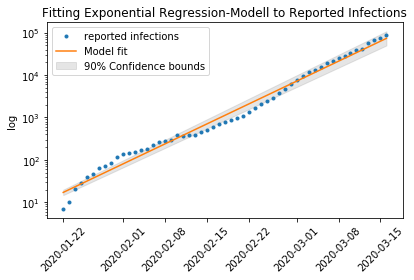

In [7]:
# Define Variables 
df_ts = df_i_rest;
nd = df_ts.shape[0] # look at the last nd days

# calculate days since day0
Xtmp = df_ts.index.map(dt.datetime.toordinal).values.reshape(-1, 1)

# set variables
X = (Xtmp[-nd:] - Xtmp[0] +1).reshape(-1, 1)
y = df_ts.values.reshape(-1, 1)
y_reg = y[-nd:]

#define linear function to be fit
def fun_exp(x,a,b):
    return (a + b*x)

# use curve_fit to fit the function
popt, pcov = curve_fit(fun_exp,X.flatten(),np.log(y_reg.flatten()))

# calculate model predicts
y_hat = np.exp(fun_exp(X,*popt))

# calcuate r2-score of regression
print('R2-Score: %4.2f' % r2_score(y_reg,y_hat))

#calculate confidence band
ci = 0.90
nstd = stats.norm.ppf((1.+ci)/2)

#stdev errors (see curve_fit documentation)
perr = np.sqrt(np.diag(pcov))
popt_up = popt + nstd*perr
popt_down = popt - nstd*perr

#Plot
xpl = df_ts.index
xpl2 = df_ts.index[-nd:]

ycb_up = np.exp(fun_exp(X,*popt_up)).flatten()
ycb_down = np.exp(fun_exp(X,*popt_down)).flatten()

plt.figure()
plt.semilogy(xpl,y,'.',label='reported infections');
plt.semilogy(xpl2,y_hat, label='Model fit');
plt.fill_between(xpl2, ycb_up, ycb_down, color='gray', alpha=0.2, label='%d%% Confidence bounds'%(ci*100));

plt.ylabel('log')
plt.title('Fitting Exponential Regression-Modell to Reported Infections')
plt.xticks(rotation=45);
plt.legend();
#plt.xlim(left=pd.to_datetime('2020/02/01'))
plt.tight_layout()
plt.savefig('Bilder/ModelFit.png', bbox_inches='tight')


assuming ongoing exponential growth, the number of infections will likely grow from 86426 to 638898 in 14 days (+ 739%) 


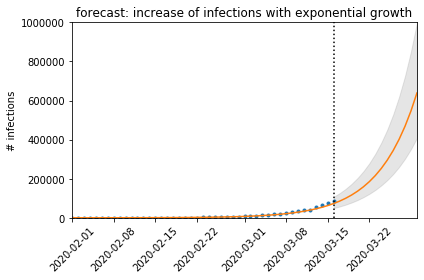

In [8]:
# Based on the fitted model, we want to predict the development of the infections of the next 2 weeks days
nDays = 14
date_start = df_ts.index.min()
date_end = date_latest + dt.timedelta(days=nDays)
X2_date = pd.date_range(start=date_start, end=date_end)
X = np.arange(1,len(X2_date)+1).reshape(-1,1)

#Plot
xpl = X2_date
y_hat = np.exp(fun_exp(X,*popt))
ycb_up = np.exp(fun_exp(X,*popt_up)).flatten()
ycb_down = np.exp(fun_exp(X,*popt_down)).flatten()

# plot
plt.figure()
plt.plot(xpl[0:len(y)],y,'.')
plt.plot(xpl,y_hat);

plt.fill_between(xpl[-nDays-1:], ycb_up[-nDays-1:], ycb_down[-nDays-1:], color='gray', alpha=0.2);
plt.axvline(date_latest,color='k',linestyle=':');

plt.xticks(rotation=45);
plt.xlim(left=pd.to_datetime('2020/02/01'), right = date_end)
plt.ylim(top = 1e6, bottom=0)
plt.ylabel('# infections')
plt.title('forecast: increase of infections with exponential growth')
plt.tight_layout()
plt.savefig('Bilder/forecast.png', bbox_inches='tight')
# plt.ylim(top=2e5)

# relative growth
increase = 100*y_hat[-1]/y[-1]
print('assuming ongoing exponential growth, the number of infections will likely grow from %4.0f to %4.0f in %d days (+%4.0f%%) ' % (y[-1], y_hat[-1], nDays, increase))

